In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.linalg import norm

import pickle
#from bunch import bunchify

import cav as cav

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)




Using TensorFlow backend.


In [2]:
model = load_model('v3_model.h5')

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'


label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [5]:
#activation_dir

In [6]:
## Run specific CAV
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

#bottleneck = bottlenecks[0]
bottleneck = 'mixed9'
target_class = 'zebra'
concepts = ['banded_sub_1', 'random500_0']

#act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)
#acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
#cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir='cavs')

## Load CAV

In [41]:
target_class = 'great_dane_sub_1'
target_class_name = 'Great_Dane'
concept_p = 'woman_sub_1'

#target_class = 'cab'
#target_class_name = 'cab'
#concept_p = 'yellow_sub_1'

target_class = 'lots_of_lions'
target_class = 'lots_of_zebras'
target_class = 'horizontal_zebras'


target_class_name = 'zebra'
concept_p = 'striped_sub_1'
concept_p = 'grassland_sub_3'


#bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
bn_names = ['mixed9']
layer = bn_names[0]

num_random = 1
concept_n = 'random500_0'
split_seed_list = [1]
split_seed = split_seed_list[0]

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(500),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

'''
orig_cav = make_orig_cav(x_train,y_train)
orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

marg_seeds = np.empty((100,orig_cav.shape[0]))
for seed in range(100):
    marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
marg_cav = marg_seeds.mean(axis=0)
marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
'''
x_train_p_list,x_train_n_list =[],[]
for idx,a in enumerate(x_train):
    if y_train[idx] == 1:
        x_train_n_list.append(a)
    else:
        x_train_p_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p - mu_n
mean_score = comp_tcav(target_class_name,cav_params,acts_class,layer)
print(mean_score)
#cav_params = make_log_cav(x_train,y_train)
#log_score = comp_tcav(target_class_name,cav_params,acts_class,layer)
#print(log_score)

0.74


In [77]:
acts_class.shape

(150, 8, 8, 2048)

In [42]:
a,acts_class = get_acts_for_concept(concept_p,layer)

In [78]:
a = acts_class.reshape(150,8*8*2048)

In [48]:
this_cav = cav_params
concept_dir = os.path.join(working_dir,'concepts/'+target_class)
concept_dir = os.path.join(working_dir,'concepts/'+concept_p)

image_list = files_from_dir_ext(concept_dir,'jp')
image_list.sort()

In [49]:
len(image_list)

500

In [80]:
m = get_magnitude_list(target_class_name,this_cav,acts_class,layer)

In [81]:
(m < 0).sum() / m.shape[0]

0.02

In [50]:
#mu_p
rank_dist = {}

for idx,img in enumerate(image_list):
    this_act = a[idx]
    dist = euclidean_distance(mu_p,this_act)
    rank_dist[img] = dist
    

In [83]:
rank_mag = {}
for idx,img in enumerate(image_list):
    rank_mag[img] = m[idx]

In [84]:
#a

In [85]:
rank_cos = {}

for idx,img in enumerate(image_list):
    this_act = a[idx]
    cos = cosine_similarity(this_cav,this_act)
    class_id = mymodel.label_to_id(target_class_name)
    rank_cos[img] = cos


In [51]:
#rank_1 = sorted(rank_cos.items(), key=operator.itemgetter(1),reverse=True)
#rank_2 = sorted(rank_mag.items(), key=operator.itemgetter(1),reverse=False)
rank_3 = sorted(rank_dist.items(), key=operator.itemgetter(1),reverse=False)

In [52]:
#rank_3[0][1]

In [53]:
len(rank_3)

500

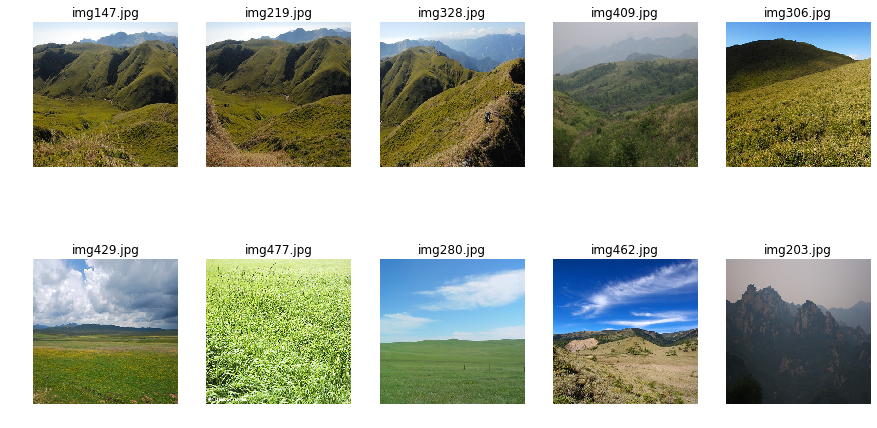

In [59]:
w, h = 120, 120
fig = plt.figure(figsize=(15, 8))
columns, rows = 5, 2

start = 1

for i in range(1, columns*rows +1):
    img, cos = rank_3[start + i - 2]
    img_name = img
    img_path = os.path.join(concept_dir,img)
    img = image.load_img(img_path, target_size=(299, 299))
    fig.add_subplot(rows, columns, i)
    plt.title(round(cos,4))
    plt.title(img_name)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [37]:
cos

-0.09620236158246306

## Generate Activations

In [ ]:
for img_path in image_list:
    filename = img_path

    img = np.array(PIL.Image.open(tf.gfile.Open(filename, 'rb')).convert('RGB').resize((299,299), PIL.Image.BILINEAR))
    img = np.float32(img) / 255.0
    
    acts_1 = mymodel.run_examples([img], 'mixed9')
    acts_shaped =  mymodel.reshape_activations(acts_1).squeeze()
    acts_shaped = acts_shaped.reshape(-1,1)
    cos = cosine_similarity(cav_1,acts_shaped)
    new_rank[img_path] = cos

new_sorted_rank = sorted(new_rank.items(), key=operator.itemgetter(1),reverse=True)

In [13]:
acts.keys()

dict_keys(['suit', 'banded_sub_1'])

In [29]:
# cosine similarity
def cosine_similarity(v1,v2):
    # compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy / math.sqrt(sumxx*sumyy)

## Sort Images by CAV

In [33]:
# loop through files

cav_1 = this_cav.cavs[0]
cav_1 = cav_1.reshape(-1,1)

new_rank = {}

#for img_path, cos_sim in sorted_rank:
for img_path in image_list:
    filename = img_path

    img = np.array(PIL.Image.open(tf.gfile.Open(filename, 'rb')).convert('RGB').resize((299,299), PIL.Image.BILINEAR))
    img = np.float32(img) / 255.0
    
    acts_1 = mymodel.run_examples([img], 'mixed9')
    acts_shaped =  mymodel.reshape_activations(acts_1).squeeze()
    acts_shaped = acts_shaped.reshape(-1,1)
    cos = cosine_similarity(cav_1,acts_shaped)
    new_rank[img_path] = cos

new_sorted_rank = sorted(new_rank.items(), key=operator.itemgetter(1),reverse=True)

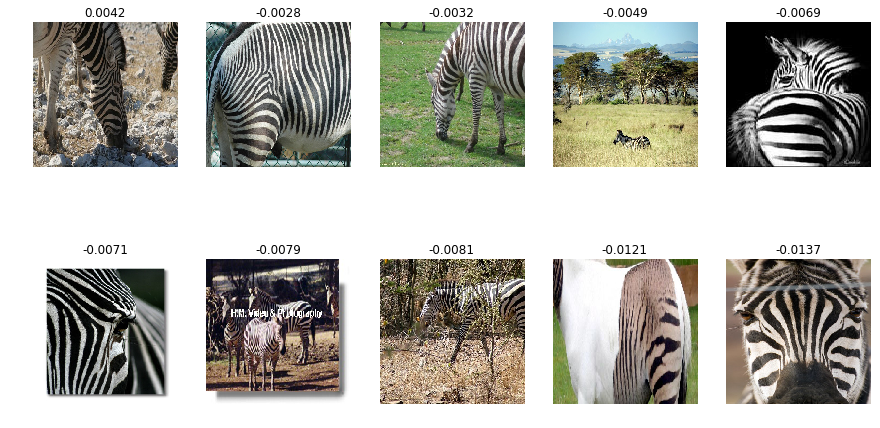

In [37]:
# plot by rank
w, h = 120, 120
fig = plt.figure(figsize=(15, 8))
columns, rows = 5, 2

start = 1

for i in range(1, columns*rows +1):
    img_path, cos = new_sorted_rank[start + i - 2]
    img = image.load_img(img_path, target_size=(299, 299))
    fig.add_subplot(rows, columns, i)
    plt.title(round(cos[0],4))
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Perturb Activations

In [6]:
## first_part
tf.logging.set_verbosity(0)

to_mixed_9 = model.layers[279]
to_mixed_9.get_input_at(0)

mixed_9 = model.layers[280]
mixed_9.get_input_at(0)

first_part_endpoints = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=to_mixed_9.output[0].name,
    prediction=to_mixed_9.output[0].name,
    prediction_tensor=to_mixed_9.output[0],
)

first_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], first_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [7]:
## second_part
tf.logging.set_verbosity(0)
mixed_9 = model.layers[280]
mixed_9.get_input_at(0)

second_part_endpoints = dict(
    input=mixed_9.name,
    input_tensor=mixed_9.input,
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)


second_part_model = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], second_part_endpoints, 
        'InceptionV3_public', (-1, 1))

In [1418]:
## load CAV
class_1 = 'striped_sub_1'
class_2 = 'random500_1'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)

In [1419]:
cav_direction = this_cav.cavs[0]

In [1335]:
this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir(this_dir)

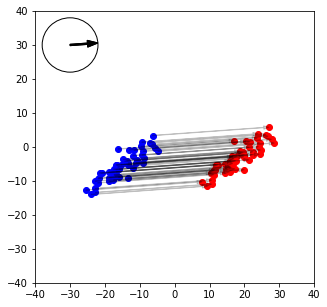

In [556]:
fig = plt.figure(figsize=[5,5])

this_cav = cav_direction
plt.scatter(x_orig[0], x_orig[1], color = 'b')
plt.scatter(x_new[0], x_new[1], color = 'r')

ax = plt.gca()

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax.add_patch(circ)

#plt.scatter(cav_pca[0], cav_pca[1], color = 'b')


cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8

arrow_start = [-30,30]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

for i in range(x_orig.shape[1]):
    arrow_start = x_orig[:,i]
    dx,dy = x_new[:,i] - x_orig[:,i]
    
    my_arrow_3 = plt.arrow(arrow_start[0], arrow_start[1], dx, dy,width=.1,length_includes_head=True,head_width=1,fc='k', ec=None,alpha=.1)
    ax.add_patch(my_arrow_3)

xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])

fig_path = 'new_figs/tmp.png'

path = os.path.join(working_dir,fig_path)
plt.savefig(path,dpi=200)


In [557]:
layer = 'mixed9'

#my_class = 'zebra_50'
concept_p,concept_n = 'striped_sub_1','random500_0'
acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
#_,acts_class = get_acts_for_concept(my_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))
idx_array = np.arange(100)

x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(x, y, idx_array, test_size=0.33, stratify=y,random_state=1,)

#cav_1 = make_orig_cav(x_train,y_train)

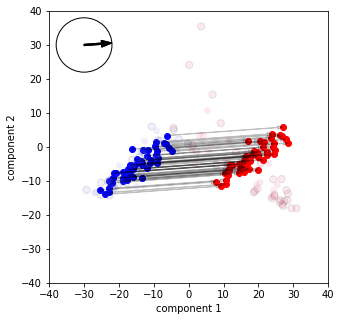

In [558]:
fig = plt.figure(figsize=[5,5])

ax = plt.gca()
plt.scatter(x_orig[0], x_orig[1], color = 'b')
plt.scatter(x_new[0], x_new[1], color = 'r')

for i in range(x_orig.shape[1]):
    arrow_start = x_orig[:,i]
    dx,dy = x_new[:,i] - x_orig[:,i]
    
    my_arrow_3 = plt.arrow(arrow_start[0], arrow_start[1], dx, dy,width=.1,length_includes_head=True,head_width=1,fc='k', ec=None,alpha=.1)
    ax.add_patch(my_arrow_3)

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax.add_patch(circ)

#plt.scatter(cav_pca[0], cav_pca[1], color = 'b')


cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8

arrow_start = [-30,30]
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)


sPCA_comps = pca_components
#light_blue,light_red = '#b3b8fb','#f6889f'
blue1,red1='#6b73df','#ea385c'

train_embed = np.dot(sPCA_comps, x_train.T)
test_embed = np.dot(sPCA_comps, x_test.T)
c_train = [red1 if y == 0 else blue1 for y in y_train]
c_test = [red1 if y == 0 else blue1 for y in y_test]

plt.scatter(train_embed[0], train_embed[1], color = c_train, alpha = .1, edgecolor='black', s=50)
plt.scatter(test_embed[0], test_embed[1], color = c_test, alpha = .1, edgecolor=None, linewidths=0 ,s=50)

plt.xlabel('component 1')
plt.ylabel('component 2')

plt.xlim([-40,40])
plt.ylim([-40,40])
plt.savefig('new_figs/tmp.png',dpi=400)

In [183]:
this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir(this_dir)

In [185]:
#imgs

In [310]:
# perturb
num_idx = 150

alpha_list = np.linspace(0,.0000000001,2)

to_concept = class_1
acts_list_2 = np.empty((num_idx,alpha_list.shape[0],131072))
z_list_2 = np.empty((num_idx,alpha_list.shape[0]))
for idx in range(num_idx):
    for a_idx,this_alpha in enumerate(alpha_list):

        img_path = os.path.join(this_dir,imgs[idx])
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = np.array(img)
        img_new_dims = np.expand_dims(img_array, axis=0)
        img_input = preprocess_input(img_new_dims)

        pred_1 = first_part_model.get_predictions(img_input)
        pred_1 = np.expand_dims(pred_1, axis=0)

        pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*this_alpha)
        pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
        pred_2 = second_part_model.get_predictions(pred_1_pert)
        dec = decode_predictions(pred_2, top=1000)

        z = None
        for d in dec[0]:
            if d[1] =='zebra':
                z = d[2]
        z_list_2[idx][a_idx] = z
        acts_list_2[idx][a_idx] = pred_1_pert.reshape(-1)

In [351]:
img_path = os.path.join(this_dir,imgs[idx])
img = image.load_img(img_path, target_size=(299, 299))
img_array = np.array(img)
img_new_dims = np.expand_dims(img_array, axis=0)
img_input = preprocess_input(img_new_dims)
pred_1 = first_part_model.get_predictions(img_input)
pred_1 = np.expand_dims(pred_1, axis=0)
    
def z_from_alpha(alpha):
    
    pred_1_pert = np.reshape(pred_1,-1)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    label = 'zebra'
    z1 = find_p(dec,label)

    pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*alpha)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    label = 'zebra'
    z2 = find_p(dec,label)
    
    return z2 - z1

In [329]:
z_from_alpha(1)

(0.9385825, 0.9385825)

In [508]:
def find_p(dec,label):
    z = None
    for d in dec[0]:
        if d[1] ==label:
            z = d[2]
    return z

In [309]:
np.linspace(0,.0000000001,2)

array([0.e+00, 1.e-10])

In [307]:
#z_list_2

In [317]:
from sympy import *

In [685]:
my_limit = limit(z_from_alpha(alpha), alpha, 0, dir="+")

In [686]:
my_limit

-0.000220060

In [687]:
alpha

0.05

In [4]:
def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e.lower()]
    return this_ext

In [1326]:
# perturb
num_idx = 150

this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir_ext(this_dir,'jp')
this_cav = cav_direction

to_concept = class_1
z_list_3 = np.empty(num_idx)
for idx in range(num_idx):
    img_path = os.path.join(this_dir,imgs[idx])
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = np.array(img)
    img_new_dims = np.expand_dims(img_array, axis=0)
    img_input = preprocess_input(img_new_dims)
    pred_1 = first_part_model.get_predictions(img_input)
    pred_1 = np.expand_dims(pred_1, axis=0)
    
    pred_1_pert = np.add(np.reshape(pred_1,-1),0)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    label = 'zebra'
    z1 = find_p(dec,label)

    z2 = limit((zz_from_alpha(alpha,pred_1,this_cav,label)-z1)/alpha,alpha,0, dir="+")
    
    z_list_3[idx] = z2

In [1327]:
idx

149

In [1328]:
#z_list_3

In [1329]:
(z_list_3 > 0).sum() / z_list_3.shape[0]

0.9533333333333334

In [594]:
#plt.hist(z_list_3)

In [688]:
def zz_from_alpha(alpha,pred_1,cav_direction,label):
    pred_1_pert = np.add(np.reshape(pred_1,-1),cav_direction*alpha)
    pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    pred_2 = second_part_model.get_predictions(pred_1_pert)
    dec = decode_predictions(pred_2, top=1000)
    z2 = find_p(dec,label)
    return z2

In [338]:
img_path

'concepts/lots_of_zebras/img458.jpg'

In [343]:
#acts_orig

-0.015300913723170202

In [ ]:
## does this match TCAV score??

In [1322]:
## class acts
concept_p = 'lots_of_zebras'
_,class_acts = get_acts_for_concept(concept_p,layer)

In [1323]:
this_cav = cav_direction
target_class = 'zebra'
bottleneck_name = layer
m = get_magnitude_list(target_class,this_cav,class_acts,bottleneck_name)


In [1324]:
(m < 0).sum() / m.shape[0]

0.98

In [1325]:
(a > 0).sum() / a.shape[0]

0.6466666666666666

In [899]:
a.argmax(),a.max()

(110, 0.001817028969526291)

In [900]:
a.argmin(),a.min()

(11, -2.142769517377019e-05)

In [992]:
np.where(a > .001)[0].shape[0] / a.shape[0]

0.9666666666666667

In [993]:
np.where(m > .001)[0].shape[0] / m.shape[0]

0.013333333333333334

In [1000]:
np.where(lion_m > .001)[0].shape[0] / lion_m.shape[0]

0.006666666666666667

In [1005]:
np.where(m > .001)

(array([ 62, 138]),)

In [1009]:
np.where(-m > .001)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149]),)

In [1045]:
np.where(lion_a > .001)[0].shape[0] / lion_a.shape[0]

0.03333333333333333

In [1008]:
#m

In [ ]:
lion_a

In [1011]:
#lion_a = a
#lion_m = m
zebra_a = a
zebra_m = m

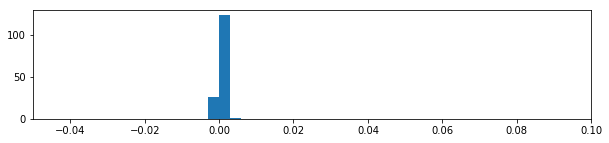

In [988]:
fig = plt.figure(figsize=[10,2])

xmin = -.05
xmax = .1
plt.xlim([xmin,xmax])
_ = plt.hist(lion_a,bins=51,range=(xmin,xmax))

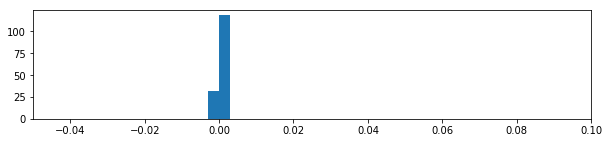

In [1098]:
fig = plt.figure(figsize=[10,2])

xmin = -.05
xmax = .1
plt.xlim([xmin,xmax])
_ = plt.hist(a,bins=51,range=(xmin,xmax))

In [906]:
idx = 11

In [907]:
imgs[idx]

'img132.jpg'

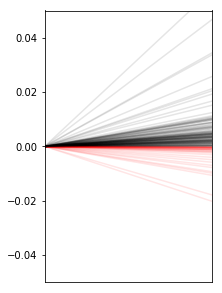

In [1462]:
fig = plt.figure(figsize=[3,5])

#plt.xlabel('component 1')
#plt.ylabel('component 2')
plt.xlim([0,1])
plt.ylim([-.05,.05])
plt.xticks([])

#a = lion_a

a = -m_1_s_1

c_list = ['black' if a_ > 0 else 'red' for a_  in a]

for z,c in zip(a,c_list):
    if c == 'black':
        alpha = .1
    else:
        alpha = .1
    #print(z)
    _ = plt.plot([0,1],[0,z], color=c,alpha = alpha)

plt.savefig('new_figs/tmp.png',dpi=400,bbox_inches='tight')

In [1375]:
147/150

0.98

In [1118]:
my_cav = this_cav.cavs[0]

In [1111]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [781]:
img_path = 'concepts/lots_of_zebras/' + imgs[9]

In [1443]:
class_1 = 'striped_sub_1'
class_2 = 'random500_0'
layer = 'mixed9'
lm_type = 'linear'

cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cav_dir/' + cav_name + '.pkl'

path = os.path.join(working_dir, sub_path)
this_cav = cav.CAV.load_cav(path)
my_cav = this_cav.cavs[0]
orig_cav = my_cav

concept_p = class_1
concept_n = class_2
layer = 'mixed9'
target_class = 'lots_of_zebras'

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=1)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_1_s_1 = tmp_seeds.mean(axis=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=3)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_1_s_2 = tmp_seeds.mean(axis=0)

concept_n = 'random500_1'
acts_n,_ = get_acts_for_concept(concept_n,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=1)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_2_s_1 = tmp_seeds.mean(axis=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=3)

tmp_seeds = np.empty((100,my_cav.shape[0]))
for seed in range(100):
    tmp_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
cav_2_s_2 = tmp_seeds.mean(axis=0)


In [1444]:
num_idx = 150

this_dir = 'concepts/lots_of_zebras/'
imgs = files_from_dir_ext(this_dir,'jp')

target_class = 'zebra'
my_cav = orig_cav

to_concept = class_1
a = np.empty(num_idx)
m = np.empty(num_idx)
#m_orig = np.empty(num_idx)
m_1_s_1 = np.empty(num_idx)
m_1_s_2 = np.empty(num_idx)
m_2_s_1 = np.empty(num_idx)
m_2_s_2 = np.empty(num_idx)

for idx in range(num_idx):
    img_path = os.path.join(this_dir,imgs[idx])
    img = prep2(img_path)
    this_img = np.expand_dims(img, axis=0)
    acts = get_acts_for_layer_new(layer,this_img)
    
    #class_id = 340
    class_id = mymodel.label_to_id(target_class)
    this_m = get_magnitude(acts, class_id,my_cav, bottleneck_name)
    m[idx] = this_m
    
    m_1_s_1[idx] = get_magnitude(acts, class_id,cav_1_s_1, bottleneck_name)
    m_1_s_2[idx] = get_magnitude(acts, class_id,cav_1_s_2, bottleneck_name)
    m_2_s_1[idx] = get_magnitude(acts, class_id,cav_2_s_1, bottleneck_name)
    m_2_s_2[idx] = get_magnitude(acts, class_id,cav_2_s_2, bottleneck_name)
    
    #this_m = get_magnitude(acts, class_id,orig_cav, bottleneck_name)
    #m_orig[idx] = this_m
    
    #pred_1 = acts
    #pred_1_pert = np.add(np.reshape(pred_1,-1),0)
    #pred_1_pert = pred_1_pert.reshape(1,8,8,2048)
    #pred_2 = second_part_model.get_predictions(pred_1_pert)
    #dec = decode_predictions(pred_2, top=1000)
    
    #z1 = find_p(dec,target_class)

    #z2 = limit((zz_from_alpha(alpha,pred_1,my_cav,target_class)-z1)/alpha,alpha,0, dir="+")
    
    #a[idx] = z2

In [1446]:
#np.where(a > 0)[0].shape[0] / a.shape[0]

In [1447]:
#np.where(a > .001)[0].shape[0] / a.shape[0]

In [1448]:
for m in [m_1_s_1,m_1_s_2,m_2_s_1,m_2_s_2]:
    print(np.where(m < 0)[0].shape[0] / m.shape[0])

0.7666666666666667
0.68
0.37333333333333335
0.3933333333333333


In [1464]:
#m_1_s_2 == m_2_s_2

In [1416]:
np.where(m < -.001)[0].shape[0] / m.shape[0]

0.03333333333333333

In [1369]:
#np.where(m_orig < 0)[0].shape[0] / m_orig.shape[0]

In [1290]:
#m_orig

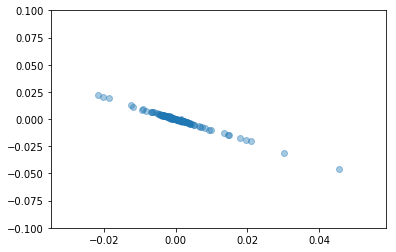

In [1109]:
plt.ylim([-.1,.1])
plt.ylim([-.1,.1])


plt.scatter(a,m,alpha = .4)

In [841]:
#this_cav

In [935]:
concept_p = 'lots_of_lions'
_,class_acts = get_acts_for_concept(concept_p,layer)

In [1010]:
#target_class
comp_tcav(target_class,my_cav,class_acts,bottleneck_name)

0.5771812080536913

In [937]:
target_class

'zebra'

In [1292]:
import pandas as pd

In [1505]:
columns = ['target_class','layer','concept_p','concept_n','split_seed','orig_score','marg_score','mean_score']
df = pd.DataFrame(columns = columns)

In [1506]:
pickle.dump(df,open('df_orig.pkl', 'wb'))

In [ ]:
target_class = 'zebra_50'
target_class_name = 'zebra'
class_1_list = ['striped_sub_1']

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
#bn_names = ['mixed9']

df = pickle.load(open('df_orig.pkl', 'rb'))

num_random = 1
split_seed_list = [1]

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                #concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(50)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    orig_cav = make_orig_cav(x_train,y_train)
                    orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

                    marg_seeds = np.empty((100,orig_cav.shape[0]))
                    for seed in range(100):
                        marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    marg_cav = marg_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_n_list.append(a)
                        else:
                            x_train_p_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    mean_cav = mu_p - mu_n
                    mean_score = comp_tcav(target_class_name,mean_cav,acts_class,layer)

                    #eta_p = np.median(x_train_p,axis=0)
                    #eta_n = np.median(x_train_n,axis=0)
                    #median_cav = eta_p - eta_n
                    #median_score = comp_tcav(target_class_name,median_cav,acts_class,layer)
                    
                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':orig_score,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score,}
                                 #'median_score':median_score,}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_orig.pkl', 'wb'))
print('### did write ###')



running zebra_50, mixed0, striped_sub_1, random500_0
running zebra_50, mixed1, striped_sub_1, random500_0
running zebra_50, mixed2, striped_sub_1, random500_0
running zebra_50, mixed3, striped_sub_1, random500_0
running zebra_50, mixed4, striped_sub_1, random500_0
running zebra_50, mixed5, striped_sub_1, random500_0


In [1494]:
df

,target_class,layer,concept_p,concept_n,split_seed,orig_score,marg_score,mean_score,median_score
0,lots_of_zebras,mixed9,striped_sub_1,random500_0,1,0.986667,0.766667,0.593333,0.453333
0,lots_of_zebras,mixed9,striped_sub_1,random500_0,2,0.333333,0.766667,0.573333,0.333333


In [1482]:
## CAV loop
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_zebras'
target_class_name = 'zebra'
#class_1 = 'grassland_sub_1'

class_1_list = ['striped_sub_1']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9']#,'mixed10']
bn_names = ['mixed9','mixed6']

df = pickle.load(open('df_var1.pkl', 'rb'))

num_random = 5

split_seed_list = [1,2,3,4,5,6,7,8,9,10]
#split_seed_list = [1,2]

for concept_p in class_1_list:
    for layer in  bn_names:
        for class_idx in range(num_random):
            for split_seed in split_seed_list:
                concept_n = 'random500_' + str(class_idx)
                concept_n = 'N_' + str(class_idx)
                subset = df[(df['target_class']==target_class) & 
                        (df['layer']==layer) & 
                        (df['concept_p']==concept_p) &
                        (df['concept_n']==concept_n) &
                        (df['split_seed']==split_seed)]
                if len(subset) == 0:
                    print(f'running {target_class}, {layer}, {concept_p}, {concept_n}')

                    acts_p,_ = get_acts_for_concept(concept_p,layer)
                    acts_n,_ = get_acts_for_concept(concept_n,layer)
                    _,acts_class = get_acts_for_concept(target_class,layer)

                    x = np.concatenate((acts_p,acts_n))
                    y = np.concatenate((np.zeros(50),np.ones(500)))

                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

                    cav_1 = make_orig_cav(x_train,y_train)
                    score_1 = comp_tcav(target_class_name,cav_1,acts_class,layer)

                    cav_2_seeds = np.empty((100,cav_1.shape[0]))
                    for seed in range(100):
                        cav_2_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
                    cav_2 = cav_2_seeds.mean(axis=0)
                    marg_score = comp_tcav(target_class_name,cav_2,acts_class,layer)
                    
                    x_train_p_list,x_train_n_list =[],[]
                    for idx,a in enumerate(x_train):
                        if y_train[idx] == 1:
                            x_train_p_list.append(a)
                        else:
                            x_train_n_list.append(a)

                    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

                    mu_p = (x_train_p).mean(axis=0)
                    mu_n = (x_train_n).mean(axis=0)
                    cav_3 = mu_n - mu_p
                    mean_score = comp_tcav(target_class_name,cav_3,acts_class,layer)

                    this_dict = {'target_class':target_class,
                                 'layer':layer,
                                 'split_seed':split_seed,
                                 'concept_p':concept_p,
                                 'concept_n':concept_n,
                                 'orig_score':score_1,
                                 'marg_score':marg_score,
                                 'mean_score':mean_score}
                    df = df.append([this_dict])
                else:
                    print(f'already in df {target_class}, {layer}, {concept_p}, {concept_n}')
            
pickle.dump(df,open('df_var1.pkl', 'wb'))
print('### did write ###')



already in df lots_of_zebras, mixed9, striped_sub_1, N_0
already in df lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_0
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zebras, mixed9, striped_sub_1, N_1
running lots_of_zeb

In [89]:
### adding perturbations

In [349]:
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_zebras'

target_class_name = 'zebra'

class_1_list = ['striped_sub_1']

bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed9']

num_random = 1
split_seed_list = [1]

layer = bn_names[0]
split_seed = split_seed_list[0]
concept_n = 'random500_0'
concept_p = class_1_list[0]

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)
concept_random = 'N_9'
acts_random,_ = get_acts_for_concept(concept_random,layer)
concept_noise = 'noise_color'
acts_noise,_ = get_acts_for_concept(concept_noise,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

In [409]:
num_to_concat = 50
list_of_idx = np.arange(500)
np.random.shuffle(list_of_idx)
this_idx = list_of_idx[:num_to_concat]
x_train_new,y_train_new = x_train,y_train
for idx in this_idx:
    x_train_new = np.concatenate((x_train_new, np.expand_dims(acts_random[idx],axis=0)))
    y_train_new = np.concatenate((y_train_new, np.array([0])))

In [380]:
#num_to_concat = 10
#list_of_idx = np.arange(50)
#np.random.shuffle(list_of_idx)
#this_idx = list_of_idx[:num_to_concat]
#x_train_new,y_train_new = x_train,y_train
#for idx in this_idx:
#    x_train_new = np.concatenate((x_train_new, np.expand_dims(acts_noise[idx],axis=0)))
#    y_train_new = np.concatenate((y_train_new, np.array([0])))

In [410]:
x_train_p_list,x_train_n_list =[],[]
for idx_2,a in enumerate(x_train):
    if y_train[idx_2] == 0:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p,x_train_n = None,None
x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p,mu_n = None,None
mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p-mu_n

mu_p_0 = mu_p
    
original_CAV_mean = cav_params

x_train_p_list,x_train_n_list =[],[]
for idx_2,a in enumerate(x_train_new):
    if y_train_new[idx_2] == 0:
        x_train_p_list.append(a)
    else:
        x_train_n_list.append(a)

x_train_p,x_train_n = None,None
x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p,mu_n = None,None
mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params_new_mean = mu_p-mu_n

mu_p_n = mu_p

old_score = comp_tcav(target_class_name,original_CAV_mean,acts_class,layer)
new_score = comp_tcav(target_class_name,cav_params_new_mean,acts_class,layer)

cosine_sim = cosine_similarity(cav_params_new_mean,original_CAV_mean)

In [411]:
print(old_score,new_score,cosine_sim)

0.5933333333333334 0.7266666666666667 0.8648484826303661


In [391]:
cav_params_svm_orig = make_SVM_cav(x_train,y_train,.1)
cav_params_svm_new = make_SVM_cav(x_train_new,y_train_new,.1)

old_score = comp_tcav(target_class_name,cav_params_svm_orig,acts_class,layer)
new_score = comp_tcav(target_class_name,cav_params_svm_new,acts_class,layer)
cosine_sim = cosine_similarity(cav_params_svm_new,cav_params_svm_orig)

In [392]:
print(old_score,new_score,cosine_sim)

0.6266666666666667 0.2 0.4456937640673164


In [355]:
cav_params_log_orig = make_log_cav(x_train,y_train)
cav_params_log_new = make_log_cav(x_train_new,y_train_new)

old_score = comp_tcav(target_class_name,cav_params_log_orig,acts_class,layer)
new_score = comp_tcav(target_class_name,cav_params_log_new,acts_class,layer)
cosine_sim = cosine_similarity(cav_params_log_new,cav_params_log_orig)

In [356]:
print(old_score,new_score,cosine_sim)

0.5933333333333334 0.8733333333333333 0.7381098651138268


In [413]:
orig,new = cav_params_svm_orig,cav_params_svm_new
orig,new = original_CAV_mean,cav_params_new_mean
#orig,new = cav_params_log_orig,cav_params_log_new

In [358]:
pca_c = pickle.load(open('spca_comps.pkl','rb'))

In [230]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)
pca_c = pca.components_

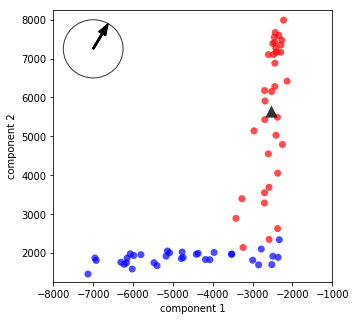

In [367]:
cav_params = orig
light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 0 else 'blue' for y in y_train]
train_embed = np.dot(x_train,pca_c.T)
plt.scatter(train_embed[:,0], train_embed[:,1], color = color_train, alpha = .7,linewidths=0,s=50)

mu_p_pca = np.dot(np.expand_dims(mu_p_0,axis=0),pca_c.T)
plt.scatter(mu_p_pca[0][0], mu_p_pca[0][1], color = 'k', alpha = .8, marker='^',s=150,linewidth=0)

plt.xlim([-8000,-1000])
plt.ylim([1250,8250])
x1,x2 = -7000,7250
radius = 750

#plt.xlim([-40,40])
#plt.ylim([-40,40])
#x1,x2 = -28,28
#radius = 10

ax = plt.gca()
circ = plt.Circle((x1,x2), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

c0,c1 =  np.dot(pca_c,cav_params)
arrow_start = [x1,x2]
cav_norm = vec_norm(np.array([c0,c1])) * radius
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=1,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = 1,zorder=5)
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=40,length_includes_head=True,head_width=200,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)

_,_ = plt.xlabel('component 1'),plt.ylabel('component 2')

#_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/tmp.png',dpi=200,bbox_inches='tight')

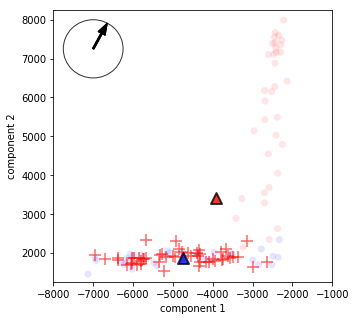

In [414]:
cav_params = new


light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

# train
color_train = ['red' if y == 0 else 'blue' for y in y_train]
train_embed = np.dot(x_train,pca_c.T)
plt.scatter(train_embed[:,0], train_embed[:,1], color = color_train, alpha = .1,linewidths=0,s=50)

for idx in this_idx:
    old_train_embed = np.dot(np.expand_dims(acts_random[idx],axis=0),pca_c.T)
    #old_train_embed = np.dot(np.expand_dims(acts_noise[idx],axis=0),pca_c.T)
    plt.scatter(old_train_embed[0][0], old_train_embed[0][1], color = 'r', alpha = .6, marker='+',s=150)
    
mu_p_pca = np.dot(np.expand_dims(mu_p_n,axis=0),pca_c.T)
plt.scatter(mu_p_pca[0][0], mu_p_pca[0][1], color = 'r', alpha = .8, marker='^',s=120,linewidth=2,edgecolor='k')

mu_p_pca = np.dot(np.expand_dims(mu_n,axis=0),pca_c.T)
plt.scatter(mu_p_pca[0][0], mu_p_pca[0][1], color = 'b', alpha = .8, marker='^',s=120,linewidth=2,edgecolor='k')

#mu_p_pca = np.dot(np.expand_dims(mu_p_40,axis=0),pca_c.T)
#plt.scatter(mu_p_pca[0][0], mu_p_pca[0][1], color = 'k', alpha = .8, marker='^',s=120,linewidth=0)

plt.xlim([-8000,-1000])
plt.ylim([1250,8250])
x1,x2 = -7000,7250
radius = 750

#plt.xlim([-40,40])
#plt.ylim([-40,40])
#x1,x2 = -28,28
#radius = 10

ax = plt.gca()
circ = plt.Circle((x1,x2), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

c0,c1 =  np.dot(pca_c,cav_params)
arrow_start = [x1,x2]
cav_norm = vec_norm(np.array([c0,c1])) * radius
#my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=1,length_includes_head=True,head_width=2,fc='k', ec=None, alpha = 1,zorder=5)
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=40,length_includes_head=True,head_width=200,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)
_,_ = plt.xlabel('component 1'),plt.ylabel('component 2')

#_,_ = plt.xticks([], []),plt.yticks([], [])
plt.savefig('new_figs/tmp.png',dpi=200,bbox_inches='tight')

In [178]:
old_train_embed[0]

array([-6421.17581731,  1833.10929126])

In [179]:
this_idx

array([463, 425])

In [415]:
source_dir = working_dir + '/concepts/'

target_class = 'lots_of_zebras'
target_class_name = 'zebra'

#target_class = 'lots_of_lions'
#target_class_name = 'lion'

class_1_list = ['striped_sub_1']
#class_1_list = ['grassland_sub_1']

bn_names = ['mixed0','mixed9','mixed6']
bn_names = ['mixed6']

num_random = 1
split_seed_list = [1]

layer = bn_names[0]
split_seed = split_seed_list[0]
concept_n = 'random500_0'
concept_p = class_1_list[0]

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)
concept_random = 'N_9'
acts_random,_ = get_acts_for_concept(concept_random,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

In [422]:
n = 25
num_to_concat = 50
ext = 'zebra_6_log_50'

is_mean = False
is_marg = False
is_svm = False
is_log = False

is_log = True

if is_mean:
    x_train_p_list,x_train_n_list =[],[]
    for idx_2,a in enumerate(x_train):
        if y_train[idx_2] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p,x_train_n = None,None
    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

    mu_p,mu_n = None,None
    mu_p = (x_train_p).mean(axis=0)
    mu_n = (x_train_n).mean(axis=0)
    cav_params = mu_p - mu_n

if is_marg:
    cav_seeds = np.empty((100,size_dict[layer]))
    for seed in range(100):
        cav_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
    cav_params = cav_seeds.mean(axis=0)

if is_log:
    cav_params = make_log_cav(x_train,y_train)
if is_svm:
    cav_params = make_SVM_cav(x_train,y_train,.1)
original_CAV = cav_params

print(comp_tcav(target_class_name,original_CAV,acts_class,layer))

try:
    add_10 = pickle.load(open(f'add_10_{ext}.pkl','rb'))
except:
    add_10 = []

for i in range(n):
    list_of_idx = np.arange(500)
    np.random.shuffle(list_of_idx)
    this_idx = list_of_idx[:num_to_concat]
    x_train_new,y_train_new = x_train,y_train
    #print(this_idx.shape)
    
    for idx in this_idx:
        x_train_new = np.concatenate((x_train_new, np.expand_dims(acts_random[idx],axis=0)))
        y_train_new = np.concatenate((y_train_new, np.array([0])))
    
    if is_mean:
        x_train_p_list,x_train_n_list =[],[]
        for idx_2,a in enumerate(x_train_new):
            if y_train_new[idx_2] == 0:
                x_train_p_list.append(a)
            else:
                x_train_n_list.append(a)

        x_train_p,x_train_n = None,None
        x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

        mu_p,mu_n = None,None
        mu_p = (x_train_p).mean(axis=0)
        mu_n = (x_train_n).mean(axis=0)
        cav_params = mu_p - mu_n

    if is_marg:
        cav_seeds = np.empty((100,size_dict[layer]))
        for seed in range(100):
            cav_seeds[seed] = make_orig_cav_seed(x_train_new,y_train_new,seed)
        cav_params = cav_seeds.mean(axis=0)

    if is_log:
        cav_params = make_log_cav(x_train_new,y_train_new)
    if is_svm:
        cav_params = make_SVM_cav(x_train_new,y_train_new,.1)
    new_score = comp_tcav(target_class_name,cav_params,acts_class,layer)

    cosine_sim = cosine_similarity(cav_params,original_CAV)
    add_10.append([this_idx,cav_params,cosine_sim,new_score])
    print(i)

pickle.dump(add_10,open(f'add_10_{ext}.pkl','wb'))


0.8733333333333333
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [6]:
from sklearn.svm import SVC

In [7]:
def make_SVM_cav(x_train,y_train,C):
    lm = SVC(kernel = 'linear',random_state=3,C=C)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

In [8]:
from sklearn import linear_model
def make_log_cav(x_train,y_train):
    lm = linear_model.LogisticRegression()
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

In [9]:
def make_orig_cav(x_train,y_train):
    lm = linear_model.SGDClassifier(alpha=.1)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

def make_orig_cav_seed(x_train,y_train,seed):
    lm = linear_model.SGDClassifier(alpha=.1,random_state=seed)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav


In [10]:
def comp_tcav(target_class,this_cav,class_acts,bottleneck_name):
    count = 0
    class_id = mymodel.label_to_id(target_class)

    for i in range(len(class_acts)):
        act_at_idx = np.expand_dims(class_acts[i], 0)
        if get_dir(act_at_idx,class_id,this_cav,bottleneck_name):
            count += 1
    score = float(count) / float(len(class_acts))
    return score

def get_dir(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod < 0

In [11]:
from sklearn import linear_model

In [12]:
def make_orig_cav_seed(x_train,y_train,seed):
    lm = linear_model.SGDClassifier(alpha=.1,random_state=seed)
    lm.fit(x_train, y_train)
    this_cav = -lm.coef_[0]
    return this_cav

In [13]:
def get_magnitude_and_grad(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod,grad


def get_magnitude_list(target_class,this_cav,class_acts,bottleneck_name):
    class_id = mymodel.label_to_id(target_class)
    magnitude_list = []
    for i in range(len(class_acts)):
        act_at_idx = np.expand_dims(class_acts[i], 0)
        this_mag = get_magnitude(act_at_idx,class_id,this_cav,bottleneck_name)
        magnitude_list.append(this_mag)
    return np.array(magnitude_list)

def get_magnitude(acts, class_id, this_cav, bottleneck_name):
    grads = sess.run(mymodel.bottlenecks_gradients[bottleneck_name], 
                 {mymodel.bottlenecks_tensors[bottleneck_name]: acts,
                 mymodel.y_input: [class_id]})
                     
    grad = np.reshape(grads, -1)
    dot_prod = np.dot(grad, this_cav)

    return dot_prod

In [15]:
#len(imgs)

## Testing linearity

In [438]:
concept_p = 'striped_sub_1'
layer = 'mixed9'

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

x_train_p_list,x_train_n_list = [],[]
for idx,a in enumerate(x_train):
    if y_train[idx] == 1:
        x_train_n_list.append(a)
    else:
        x_train_p_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p - mu_n

In [439]:
acts_n.shape

(50, 131072)

In [440]:
#mu_horse = mu_p
#cav_horse = cav_params

#mu_zebra = mu_p
#cav_zebra = cav_params

mu_stripes = mu_p
cav_stripes = cav_params

In [452]:
cosine_similarity(cav_stripes,cav_zebra)

0.4927961411113061

In [453]:
cosine_similarity(cav_horse,cav_stripes)

0.1755727244623731

In [454]:
cosine_similarity(cav_zebra,cav_horse)

0.2539533727950936

In [450]:
mu_combo = mu_horse + mu_stripes
cav_combo = cav_horse + cav_stripes

In [455]:
cosine_similarity(cav_zebra,cav_combo)

0.5110402776787344

In [188]:
cav_1 = this_cav.cavs[0]
cav_1 = cav_1.reshape(-1,1)

pred_1_shaped = pred_1.squeeze().reshape(-1,1)
cos = cosine_similarity(cav_1,pred_1_shaped)

pred_1_pert_shaped = pred_1_pert.squeeze().reshape(-1,1)
cos_pert = cosine_similarity(cav_1,pred_1_pert_shaped)

print(cos,cos_pert)

[-0.05537518] [0.24518335]


In [211]:
act = pred_1
flat_act = np.reshape(act, -1)
alpha = 2
cav_from_class = this_cav.cavs[this_cav.concepts.index(class_1)]
pert = flat_act + alpha * cav_from_class

In [16]:
def files_from_dir(a_dir):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    return onlyfiles

In [186]:
## Get CAV
working_dir = '/home/tyler/Desktop/tcav_on_azure'
subpath = 'striped_sub_1-random500_0-mixed9'
cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
path = os.path.join(working_dir, cav_path)

this_cav = cav.CAV.load_cav(path)

perturbed_act = this_cav.perturb_act(acts_1,'striped_sub_1',alpha = 20)

In [187]:
perturbed_act[0][0][0]

array([-0.47168261,  0.        , -0.33739523, ...,  0.        ,
        1.11533005,  0.        ])

In [17]:
def get_L1(act_for_L1):
    return np.linalg.norm(act_for_L1.T,1,axis = 1) / act_for_L1.shape[1]

def make_L1_cav(x_train,y_train):
    x_train_p_list,x_train_n_list =[],[]
    for idx,a in enumerate(x_train):
        if y_train[idx] == 0:
            x_train_p_list.append(a)
        else:
            x_train_n_list.append(a)

    x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)
    L1_cav = get_L1(x_train_p) - get_L1(x_train_n)
    return L1_cav

In [14]:
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    #if K.image_data_format() == 'channels_first':
    #    x = x.reshape((3, x.shape[2], x.shape[3]))
    #    x = x.transpose((1, 2, 0))
    #else:
    x = x.reshape((x.shape[0], x.shape[1], 3))
    #x /= 2.
    #x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

preprocess_input

## define functions
def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return np.expand_dims(img,axis=0)

In [15]:

def prep2(filename):
    shape=(299, 299)
    img = np.array(PIL.Image.open(open(filename, 'rb')).convert('RGB').resize(shape, PIL.Image.BILINEAR))
    # Normalize pixel values to between 0 and 1.
    img = np.float32(img) / 255.0
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        return None
    else:
        return img

this_img = np.expand_dims(prep2('concepts/random500_0/ILSVRC2012_val_00001172.JPEG'),axis=0)
    
    
    
def get_acts_for_concept(concept,layer):
    concept_dir = os.path.join(working_dir,'concepts/'+concept)
    image_list = files_from_dir_ext(concept_dir,'jp')
    image_list.sort()

    act_path = os.path.join(working_dir,'final_acts/' + concept + '-' + layer + '.pkl')

    n = size_dict[layer]
    nn = size_dict_orig[layer]

    try:
        this_dict = pickle.load(open(act_path, 'rb'))
    except:
        this_dict = {}
        
    #print(nn)
    
    acts_ran = np.zeros((len(image_list),n))
    orig = np.zeros((len(image_list),nn[1],nn[2],nn[3]))
    
    for idx,image_path in enumerate(image_list):
        if image_path not in this_dict:
            img = prep2(os.path.join(concept_dir,image_path))
            this_img = np.expand_dims(img, axis=0)
            acts_orig = get_acts_for_layer_new(layer,this_img)
            acts_ran[idx] = acts_orig.reshape(-1)
            orig[idx] = acts_orig
            this_dict[image_path] = (acts_orig.reshape(-1),acts_orig)
        else:
            acts_ran[idx],orig[idx] = this_dict[image_path]
            #print('acts already exist')

    pickle.dump(this_dict,open(act_path, 'wb'))
    
    return acts_ran,orig
def files_from_dir_ext(a_dir,ext):
    onlyfiles = [f for f in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, f))]
    this_ext = [e for e in onlyfiles if ext in e.lower()]
    return this_ext
layer_dict = dict([(layer.name, layer) for layer in model.layers])
sess = K.get_session()


acts_mixed0_f = K.function([model.input],[layer_dict['mixed0'].output])
acts_mixed1_f = K.function([model.input],[layer_dict['mixed1'].output])
acts_mixed2_f = K.function([model.input],[layer_dict['mixed2'].output])
acts_mixed3_f = K.function([model.input],[layer_dict['mixed3'].output])
acts_mixed4_f = K.function([model.input],[layer_dict['mixed4'].output])
acts_mixed5_f = K.function([model.input],[layer_dict['mixed5'].output])
acts_mixed6_f = K.function([model.input],[layer_dict['mixed6'].output])
acts_mixed7_f = K.function([model.input],[layer_dict['mixed7'].output])
acts_mixed8_f = K.function([model.input],[layer_dict['mixed8'].output])
acts_mixed9_f = K.function([model.input],[layer_dict['mixed9'].output])
acts_mixed10_f = K.function([model.input],[layer_dict['mixed10'].output])

def get_acts_for_layer_new(layer_name,input_img):
    acts = None
    if layer_name=='mixed0':
        acts = acts_mixed0_f([input_img])[0]
    if layer_name=='mixed1':
        acts = acts_mixed1_f([input_img])[0]
    if layer_name=='mixed2':
        acts = acts_mixed2_f([input_img])[0]
    if layer_name=='mixed3':
        acts = acts_mixed3_f([input_img])[0]
    if layer_name=='mixed4':
        acts = acts_mixed4_f([input_img])[0]
    if layer_name=='mixed5':
        acts = acts_mixed5_f([input_img])[0]
    if layer_name=='mixed6':
        acts = acts_mixed6_f([input_img])[0]
    if layer_name=='mixed7':
        acts = acts_mixed7_f([input_img])[0]
    if layer_name=='mixed8':
        acts = acts_mixed8_f([input_img])[0]
    if layer_name=='mixed9':
        acts = acts_mixed9_f([input_img])[0]
    if layer_name=='mixed10':
        acts = acts_mixed10_f([input_img])[0]
    
    return acts


bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']

size_dict = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict[bn] = acts_orig.reshape(-1).shape[0]
    
size_dict_orig = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict_orig[bn] = acts_orig.shape